In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt   
import numpy as np

class Particle (object):

    """Class that describes particle"""
    m = 1.0

    def __init__(self, x0=1.0, v0=0.0,  tf = 10.0, dt = 0.001):
        self.x = x0
        self.v = v0
        self.t = 0.0
        self.tf = tf
        self.dt = dt

        self.tlabel = 'time (s)'
        self.xlabel = 'x (m)'
        self.vlabel = 'v (m/s)'

        npoints = int(tf/dt) # always starting at t = 0.0
        self.npoints = npoints
        self.tarray = np.linspace(0.0, tf,npoints, endpoint = True) # include final timepoint
        self.xv0 = np.array([self.x, self.v]) # NumPy array with initial position and velocity

    def F(self, x, v, t):
        # The force on a free particle is 0
        return array([0.0])

    def RK4_step(self):
        """
        Take a single time step using RK4 midpoint method
        """

        a1 = self.F(self.x, self.v, self.t) / self.m
        k1 = np.array([self.v, a1])*self.dt

        a2 = self.F(self.x+k1[0]/2, self.v+k1[1]/2, self.t+self.dt/2) / self.m
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dt
        
        a3 = self.F(self.x+k2[0]/2, self.v+k2[1]/2, self.t+self.dt/2) / self.m
        k3 = np.array([self.v+k2[1]/2, a3])*self.dt
        
        a4 = self.F(self.x+k3[0], self.v+k3[1], self.t+self.dt) / self.m
        k4 = np.array([self.v+k3[1], a4])*self.dt

        self.x += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        
        self.t += self.dt


    def RK4_trajectory(self):  # calculate trajectory as before
        # need to reinitialize if you want to call this method and others
        x_RK4 = []
        v_RK4 = []
        for ii in range(self.npoints):
            x_RK4.append(self.x)
            v_RK4.append(self.v)
            self.RK4_step()

        self.x_RK4 = np.array(x_RK4)
        self.v_RK4 = np.array(v_RK4)


    def results(self):
        """
        Print out results in a nice format
        """

        
        print('\n\t Position and Velocity at Final Time:')
        print('Euler:')
        print('t = {} x = {} v = {}'.format(self.t, self.x , self.v))
        
        if hasattr(self, 'xv'):
            print('SciPy ODE Integrator:')
            print('t = {} x = {} v = {}'.format(self.tarray[-1], self.xv[-1, 0], self.xv[-1,1]))

    def plot(self, pt = 'trajectory'):
        """
        Make nice plots of our results
        """

        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        
        
        
        if hasattr(self,'x_RK4'):

            if pt == 'trajectory':
                ax1.plot(self.tarray, self.x_RK4, "r", label = 'RK4')
            if pt == 'phase':
                ax1.plot(self.x_RK4, self.v_RK4, "b",'.', label = 'euler')
       
        if pt == 'trajectory':
            ax1.set_xlabel(self.tlabel)
            ax1.set_ylabel(self.xlabel)
        
        if pt == 'phase':
            ax1.set_xlabel(self.xlabel)
            ax1.set_ylabel(self.vlabel)

from numpy import *
def solver_linear_damping(I, V, m, b, s, F, t):
    N = t.size - 1 # No of time intervals
    dt = t[1] - t[0] # Time step
    u = zeros(N+1) # Result array
    u[0] = I
    u[1] = u[0] + dt*V + dt**2/(2*m)*(-b*V - s(u[0]) + F[0])
    for n in range(1,N):
        u[n+1] = 1./(m + b*dt/2)*(2*m*u[n] + \
        (b*dt/2 - m)*u[n-1] + dt**2*(F[n] - s(u[n])))
    return u

In [2]:
class Pendulum(Particle):

    """Subclass of Particle Class that describes a pendulum in a harmonic potential"""
    def __init__(self, l = 9.8, nu = 0, Fd  = 0.0, omega_d = 0.0, m = 1.0, x0 = 0.0 ,v0 = 0.0, tf = 50.0, dt = 0.001):
       
        super().__init__(x0,v0,tf,dt) 
        # for pendulum x = theta [-pi, pi]
        g = 9.8
        omega0 = np.sqrt(g/l)
        
        self.l = l # length
        self.m = m # mass
        self.Fd = Fd # driving force, in units of mg
        self.omega_d = omega_d #driving frequency, in units of omega0
        self.nu = nu # viscous damping 
        self.omega0 = omega0 # natural frequency

        self.tlabel = 'time ($1/\omega_0$)'
        self.xlabel = '$\\theta$ (radians)'
        self.vlabel = '$\omega$ (radians/s)'

    # overload method to wrap x between [-pi,pi]
    def RK4_step(self):  
        Particle.RK4_step(self)
        if self.x > np.pi:
            self.x -= 2*np.pi
        elif self.x < -np.pi:
            self.x += 2*np.pi

    # overload method to wrap x between [-pi,pi]
    def scipy_trajectory(self):
        Particle.scipy_trajectory(self)
        
        x = self.xv[:,0]
        x_new = np.zeros(np.shape(x))
        x_new[0] = x[0]

        # find change in x between each point
        dx = np.diff(x)
        nx = np.shape(x)[0]
        
        for ii in range(1,nx):
            # reconstruct x array, checking for out of range values
            x_new[ii] = x_new[ii-1]+dx[ii-1]
            if x_new[ii] > np.pi:
                x_new[ii] -= 2*np.pi
            
            elif x_new[ii] < -np.pi:
                x_new[ii] += 2*np.pi
        
        self.xv_unwrap = 1.0*self.xv
        self.xv[:,0] = x_new
    
    def F(self, x, v, t):
        g = 9.8 

        F = self.Fd*np.cos(self.omega_d*t) - self.nu*v - g/self.l*np.sin(x)
        
        return F

# Problem 1

 In this problem I will simulate the motion of two identical nonlinear pendula. The only difference is a very small differences between their initial conditions. Setting the initial condition for pendulum #1: θ(t = 0) = 0.6, and for pendulum 2 is: θ(t = 0) = 0.61, Although the difference between the initial
angles is very small, ∆θ(t) (difference between the angular position of the two pendula in time increases exponentially over time.

In [8]:
#class Pendulum(Particle):
#def __init__(self, l = 9.8, nu = 0, Fd  = 0.0, omega_d = 0.0, m = 1.0, x0 = 0.0 ,v0 = 0.0, tf = 50.0, dt = 0.001):
Pendulum1 = Pendulum(x0=0)
Pendulum2 = Pendulum(x0=0.1)

In [13]:
class TwoPendulums (object):
    
    def __init__(self, l=9.8, nu=0.5, Fd=1.1, omega_d = 0.6, m = 1.0, x10 = 0.5, x20 = 0.51, v10 = 0.0, v20=0.0, 
    tf = 300.0, dt = 0.1): # 2 pendula with x1 and x2 being initial condition for each
        g = 9.8
        omega0 = np.sqrt(g/l)
        self.l = l #length
        self.m = m #mass
        self.Fd = Fd #driving force, in units of mg
        self.omega_d = omega_d #driving frequency, in units of omega0
        self.nu = nu #viscous damping
        self.omega0 = omega0 #natural frequency
        self.x1 = x10
        self.x2 = x20
        self.v1 = v10
        self.v2 = v20
        self.tf = tf
        self.dt = dt
        npoints = int(tf/dt) #always starting at t = 0.0
        self.npoints = npoints
        self.tarray = np.linspace(0.0, tf,npoints, endpoint = True)
        self.xv10 = np.array([self.x1, self.v1])
        self.xv20 = np.array([self.x2, self.v2])
  
    def F(self, x, v, t):
        g = 9.8
        F = self.Fd*np.cos(self.omega_d*t) - self.nu*v - g/self.l*np.sin(x)
        return F
   
    def derivative(self, xv, t):
        x =xv[0]
        v =xv[1]
        a = self.F(x, v, t) / self.m
        return np.ravel(np.array([v, a]))
   
    def Difference(self):
        xv1 = odeint(self.derivative, self.xv10, self.tarray)
        x1 = xv1[:,0]
        x1_new = np.zeros(np.shape(x1))
        x1_new[0] = x1[0]
        dx1 = np.diff(x1) # find change in x between each point
        nx1 = np.shape(x1)[0]
        
        for ii in range(1,nx1): # reconstruct x array, checking for out of range values
            x1_new[ii] = x1_new[ii-1]+dx1[ii-1]
            if x1_new[ii] > np.pi:
                x1_new[ii] -= 2*np.pi
            elif x1_new[ii] < -np.pi:
                x1_new[ii] += 2*np.pi
        xv2 = odeint(self.derivative, self.xv20, self.tarray)
        x2 = xv2[:,0]
        x2_new = np.zeros(np.shape(x2))
        x2_new[0] = x2[0]
        dx2 = np.diff(x2)
        nx2 = np.shape(x2)[0]
        
        for ii in range(1,nx2):
            x2_new[ii] = x2_new[ii-1]+dx2[ii-1]
            if x2_new[ii] > np.pi:
                x2_new[ii] -= 2*np.pi
            elif x2_new[ii] < -np.pi:
                x2_new[ii] += 2*np.pi
        xv1_unwrap = xv1
        xv1[:,0] = x1_new
        xv2_unwrap = xv2
        xv2[:,0] = x2_new
       
        delta_x = np.zeros(min(nx1,nx2))       
        
        for ii in range(1,min(nx1,nx2)):
                delta_x[ii] = abs(xv2[ii,0]-xv1[ii,0])
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.plot(self.tarray,delta_x,"k",label = 'Fd=1.1')
        ax2.plot(self.tarray,delta_x,"k",label = 'Fd=1.1')
        ax2.set_yscale("log")
        ax1.set_xlabel('t(s)')
        ax1.set_ylabel('$\Delta\\theta$')
        ax2.set_xlabel('t(s)')
        ax2.set_ylabel('$\Delta\\theta$')
        ax1.legend()
        ax2.legend()
        plt.tight_layout()
        plt.show()

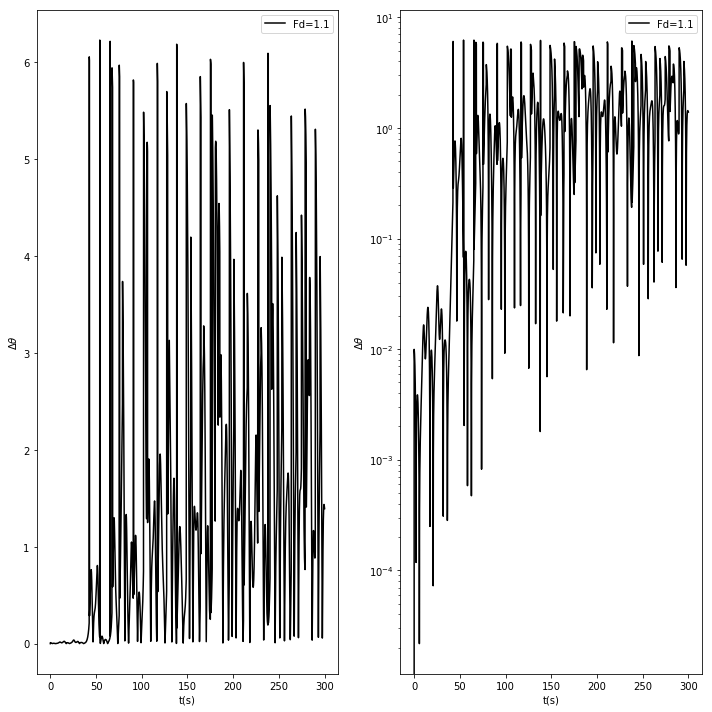

In [14]:
TwoPendulums().Difference()

# Problem 2

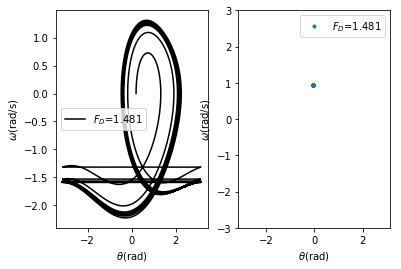

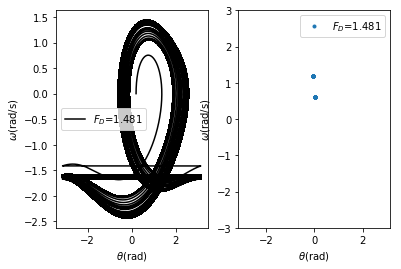

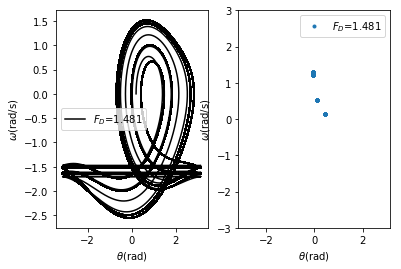

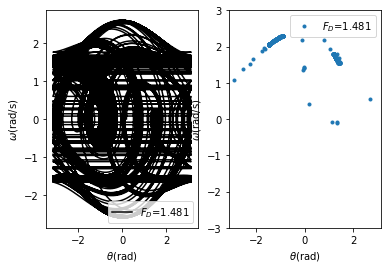

In [15]:
class Pendulum(object):
    def __init__(self, l = 9.8, nu = 0.5, Fd = 1.4, omega_d = 2/3, m=1.0, x0 = 0.2, v0=0.0,tf=10000.0, dt=0.005):
        self.g = 9.8
        self.m = m
        self.x = x0
        self.v = v0
        self.l = l
        self.Fd = Fd
        self.omega_d = omega_d
        self.nu = nu
        self.Omega0 = np.sqrt(self.g/l)

        self.t = 0.0
        self.tf = tf
        self.dt = dt 

        npoints = int(tf/dt)
        self.tarray = np.linspace(0.0, tf, npoints, endpoint = True) 
        self.xv0 = np.array([self.x, self.v])

    def F(self, x, v, t):
        return self.Fd*np.cos(self.omega_d*t) - self.nu*v - self.g/self.l*np.sin(x)
    
    def scipy_trajectory(self):
        self.xv = odeint(self.derivative, self.xv0, self.tarray) 
        x = self.xv[:,0]
        x_new = np.zeros(np.shape(x))
        x_new[0] = x[0]
        dx = np.diff(x)
        nx = np.shape(x)[0]
        for ii in range(1,nx):
            x_new[ii] = x_new[ii-1]+dx[ii-1]
            if x_new[ii] > np.pi: 
                x_new[ii] -= 2*np.pi
            elif x_new[ii] < -np.pi:
                x_new[ii] += 2*np.pi
        self.xv_unwrap = self.xv
        self.xv[:,0] = x_new
    
    def derivative(self, xv, t):
        x =xv[0]
        v =xv[1]
        a = self.F(x, v, t) / self.m
        return np.ravel(np.array([v, a]))
    def Poincare(self, transient = 20, nperiods = 100):
        T = 2*np.pi/self.omega_d
        
        n_transient = int(T*transient/self.dt)
        t_new = self.tarray[n_transient:]
        xv_poincare = self.xv[n_transient:,:]
        index = np.nonzero((t_new%T)<(self.dt/2.))[0] 
        xv_poincare = xv_poincare[index,:]
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.plot(self.xv[:, 0], self.xv[:, 1], 'k',label='$F_D$=1.481')
        ax2.plot(xv_poincare[:,0],xv_poincare[:,1],'.',label='$F_D$=1.481')
        ax1.set_xlabel('$\\theta$(rad)')
        ax1.set_ylabel('$\omega$(rad/s)')
        ax2.set_xlabel('$\\theta$(rad)')
        ax2.set_ylabel('$\omega$(rad/s)')
        ax2.set_xlim(-np.pi,np.pi)
        ax2.set_ylim(-3,3)
        ax1.legend()
        ax2.legend()
        plt.show()
            
Fd=[1.4,1.44,1.465,1.481]
for fd in Fd:
    p=Pendulum(Fd=fd)
    p.scipy_trajectory()
    p.Poincare()        
